<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Sloan-Digital-Sky-Survey_SDSS/blob/master/Tutorial_Entity_Embedding_GELU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

1. psfMag = Point spread function magnitudes : 먼 천체를 한 점으로 가정하여 측정한 빛의 밝기입니다.

2. fiberMag = Fiber magnitudes : 3인치 지름의 광섬유를 사용하여 광스펙트럼을 측정합니다. 광섬유를 통과하는 빛의 밝기입니다.

3. petroMag = Petrosian Magnitudes : 은하처럼 뚜렷한 표면이 없는 천체에서는 빛의 밝기를 측정하기 어렵습니다. 천체의 위치와 거리에 상관없이 빛의 밝기를 비교하기 위한 수치입니다.

4. modelMag = Model magnitudes : 천체 중심으로부터 특정 거리의 밝기입니다.

5. fiberID = 관측에 사용된 광섬유의 구분자


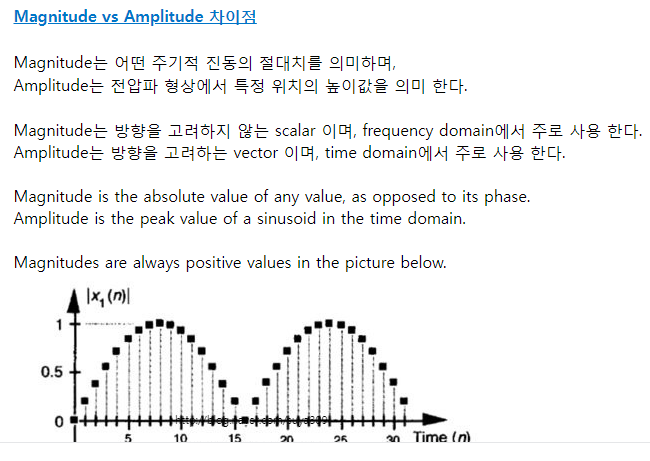

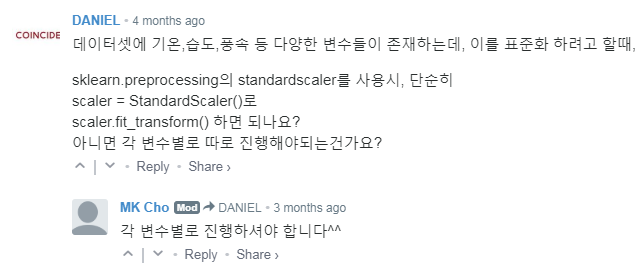

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(123) #ensure reproducibility
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거임, 2.5면 꽤 크게 나옴

#ignore warnings
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline 


import numpy as np # linear algebra
import pandas as pd 

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model



#train = pd.read_csv('drive/My Drive/데이콘_천체유형/train.csv', index_col=0)
train = pd.read_csv('drive/My Drive/데이콘_천체유형/이상치_최대한_적게_train.csv', index_col=None)
test = pd.read_csv('drive/My Drive/데이콘_천체유형/test.csv', index_col=0)
sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)

print('csv 파일 (train, test, sample)을 불러왔습니다')
print('train shape : {0}'.format(train.shape))
print('test shape : {0}'.format(test.shape))
print('='*50)
# TRAIN 데이터의 TYPE을 SAMPLE_SUBMISSION에 대응하는 가변수 형태로 변환시킵니다.
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

#train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

notin_test = list(set(train['fiberID']) - set(test['fiberID']))## 81개
in_test = list(set ( test['fiberID']) )

#print(train.shape[0])
select_train = pd.DataFrame()
for i in range(len(in_test)):
  select_train0 = train.loc[train['fiberID']==in_test[i],:]
  select_train = pd.concat([select_train, select_train0],axis=0)
select_train = select_train.sort_index()
print( 'Test에 없는 fiberID를 Train에서도 제거한 후 Train set 갯수 : %s'  % select_train.shape[0]) ## 1769개의 트레인데이터가 빠짐

###################################### fiberID에 대해서 각각 Scaling ##################################
def scalingDF_by_fID(select_train, test, use_stc=True):
  contiunuous = list(  select_train.columns.drop(['type','fiberID','type_num']) )
  needscaling0 = select_train.loc[:,contiunuous]
  needscaling0_test = test.loc[:,contiunuous]
  fID_index = list(select_train.loc[:,'fiberID'].value_counts().index)

  #fiberIDnum = select_train.loc[:,'fiberID']
  #fiberIDnum

  scaled_train = pd.DataFrame()
  scaled_test = pd.DataFrame()

  if use_stc:

    ## Train set
    sc = StandardScaler()
    sc.fit( needscaling0 )
    stc_train = pd.DataFrame(sc.transform(needscaling0),
                          columns=needscaling0.columns,
                          index = needscaling0.index)
    scaled_train = pd.concat([stc_train,   select_train.fiberID],axis=1)

    ## Test set
    stc_test = pd.DataFrame(sc.transform(needscaling0_test),
                      columns=needscaling0_test.columns,
                      index = needscaling0_test.index)
    scaled_test = pd.concat([stc_test,test.fiberID],axis=1)



  else:                     ## Train set Robustscale
    ## Train set
    rb = RobustScaler()
    rb.fit( needscaling0 )
    rbs_train = pd.DataFrame(rb.transform(needscaling0),
                          columns=needscaling0.columns,
                          index = needscaling0.index)
    scaled_train = pd.concat([rbs_train,   select_train.fiberID],axis=1)

    ## Test set
    
    rbs_test = pd.DataFrame(rb.transform(needscaling0_test),
                      columns=needscaling0_test.columns,
                      index = needscaling0_test.index)
    scaled_test = pd.concat([rbs_test,test.fiberID],axis=1)
    
  scaled_train = scaled_train.sort_index()
  scaled_test = scaled_test.sort_index()

  return scaled_train, scaled_test



tr, tst = scalingDF_by_fID(select_train=select_train, test=test, use_stc=True)


def dummies_fID(dataframe):
  import pandas as pd
  dummy = pd.get_dummies(dataframe['fiberID'], prefix='fid')
  dataframe = pd.concat( [dataframe.drop(['fiberID'],axis=1),dummy], axis=1 )


  return dataframe

  
#tr = dummies_fID(tr)
#tst = dummies_fID(tst)


tr['type_num'] = select_train.type_num

# fiberID랑 type_num 빼고 연속형의 colname
fiber_col = tr.columns[5:10].tolist()                                      ## fiberMag
other_col = tr.columns[ list(range(0,5)) + list(range(10,20)) ].tolist()  ## psfMag, modelMag, petroMag


#np.random.seed(123) #ensure reproducibility
#random_index = list(np.random.permutation(list(tr.index)))
#tr = tr.loc[random_index,:]
#train_x = tr.drop(['type_num'], axis = 1)
#train_y = tr['type_num']

#X = tr.drop(['type_num'], axis = 1)
#Y = tr['type_num']
#train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.05, random_state=42)


col_vals_dict = {c: list(tr[c].unique()) for c in tr.columns if c == 'fiberID'}

embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions


Using TensorFlow backend.


csv 파일 (train, test, sample)을 불러왔습니다
train shape : (199899, 23)
test shape : (10009, 21)
Test에 없는 fiberID를 Train에서도 제거한 후 Train set 갯수 : 198130
fiberID: 919 values


# Stochastic weight averaging (SWA)



*   Warm up 방법이라고 생각하면 될듯?






> 내가 이해하기론 이건 싱글 모델을 만들 때 마치 앙상블같은 효과를 내는 방법인 듯함. (정확하게는 여러 가중치로 모델링 한 것들의 평균을 내는 식?)

> 기존의 앙상블은 여러 모델들을, 혹은 샘플링을 다르게 해서 한다던가 하는데, 싱글 모델 관점에서 라는 이 부분이 확연한 차이가 있는 듯.



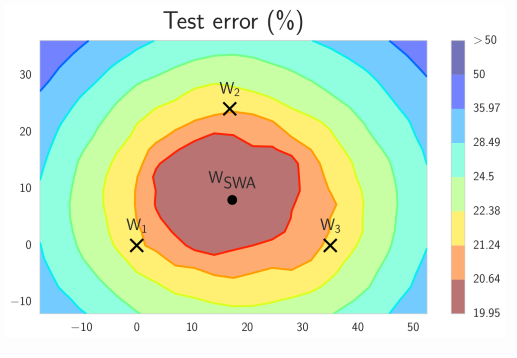

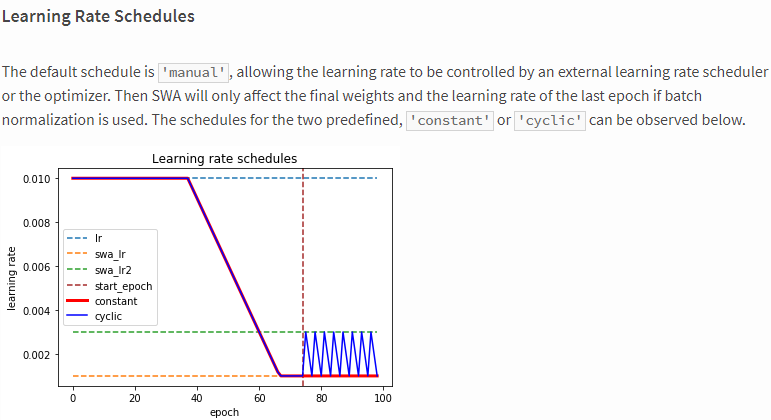

# Cosine Annealing scheduler (Warm up 과 세트)



> warm up 단계 이후에  lr을 max 와 min 값 사이에서 조절해주는 방식의 스케쥴러

> 국소 최소점(local minima) 문제가 발생하는 것을 막기 위함? learning rate를 여러가지로 돌려보면서 여러 개의 local minima를 찾아버리는 방법으로 이해가 됨

> 내가 이해하기론 learning_rate를 높은 값으로 에포크 돌리다가 일정 수의 에포크를 돌린 뒤에 설정한 시기(start_epoch) 부터 또다른 learning_rate들을 사용하여 나머지 에포크를 돌리는 것 같음. 이게 여러 가중치 (w1, w2, w3, ...) 을 만드는 방법이라고 이해하면 되려나? 


> 이 때 learning rate는 스케쥴러 설정에 따라 constant 일수도 있고 upper boundary를 정해놓아(cyclic) 왔다갔다 하게 만들 수도 있는 듯함.

> SWA를 사용시에 SGD를 optimizer로 택해야 하지만 너무느려지는 문제가 생겨버림.... Adam으로 학습을 함


# Entity Embedding Neural Net


> one-hot encoding + SMOTE >>> Entitiy Embedding >>> Entitiy Embedding +SMOTE

> Entity Embedding 이후에는 SMOTE 보다는 실제값 Resampling이 불균형처리에 좋다고 한다. (추가적인 연구와 정확한 근거가 아직 충분치 않은 듯)


In [0]:
!pip install keras-swa


  Created wheel for keras-swa: filename=keras_swa-0.1.4-cp36-none-any.whl size=8495 sha256=c4099897d56d129398b00840293f2c303a57f6a8b6d451161744a8a3e766e076
  Stored in directory: /root/.cache/pip/wheels/ec/99/c1/e08fe5eb0b807b44c15de29546ed0ce09f918d562e88368d2d
Successfully built keras-swa


In [0]:
import numpy as np
import pandas as pd

#random seeds for stochastic parts of neural network 
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, Model, load_model
from keras.layers import  Activation,  Lambda, Flatten, LeakyReLU, ELU, Dense
from keras.layers import Input, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam, SGD,RMSprop
from keras import  backend as K
from keras import metrics
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})

X_train = tr.drop(['type_num'],axis=1)
y_train = tr['type_num']
X_test = tst


def build_embedding_network():
    
    inputs = []
    embeddings = []
    

    input_fiberID = Input(shape=(1,), dtype='int32')
    embedding = Embedding(919, 50, input_length=1)(input_fiberID) ## 보통 Embedding size를 min( 50, number of categories )로 정한다고 한다.
    embedding = Dropout(0.1)(embedding)
    embedding = Reshape(target_shape=(50,))(embedding)
    inputs.append(input_fiberID)
    embeddings.append(embedding)
    
    
    input_numeric = Input(shape=(20,), dtype='float32')
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)

    x = Concatenate()(embeddings)

    x = Dense(2353, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.2)(x)

    x = Dense(2343, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.2)(x)

    x = Dense(1191, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.1)(x)

    x = Dense(1181, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.1)(x)

    x = Dense(610, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.05)(x)

    x = Dense(591, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.05)(x)

    x = Dense(572, activation='gelu')(x)
#    x = Dropout(.05)(x)
    
    output = Dense(19, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(lr=lr,
                                 #decay = lr_d
                                 ),
                  metrics=['accuracy'])
    
    return model



#converting data to list format to match the network structure
def preproc(X_train, #X_val,
            X_test):

    input_list_train = []
    #input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # of values)
    for c in embed_cols:
        raw_vals = np.unique(tr[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        #input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    #input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train,  input_list_test   #input_list_val,
      

#gini scoring function from kernel at: 
#https://www.kaggle.com/tezdhar/faster-gini-calculation
#def ginic(actual, pred):
#    n = len(actual)
#    a_s = actual[np.argsort(pred)]
#    a_c = a_s.cumsum()
#    giniSum = a_c.sum() / a_c[-1] - (n + 1) / 2.0
#    return giniSum / n
 
#def gini_normalizedc(a, p):
#    return ginic(a, p) / ginic(a, a)
# learning rate scheduler 구현
# lr을 cyclic하게 변환해줌

########### CosineAnnealingScheduler

import math
from keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        #if self.verbose &gt; 0:
        if self.verbose != 0:
        
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
csv_folder = '0215_Entity_Embedding_only'

import os
SAVEMODEL_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder
if not os.path.exists(SAVEMODEL_NEWFOLDER):
  os.mkdir(SAVEMODEL_NEWFOLDER)
SUBMISSION_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder
if not os.path.exists(SUBMISSION_NEWFOLDER):
  os.mkdir(SUBMISSION_NEWFOLDER)



Train on 182279 samples, validate on 15851 samples
Epoch 1/100
182279/182279 [==============================] - 10s 55us/step - loss: 0.5947 - acc: 0.8067 - val_loss: 0.5560 - val_acc: 0.8297
Epoch 2/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4592 - acc: 0.8431 - val_loss: 0.8315 - val_acc: 0.7378
Epoch 3/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4500 - acc: 0.8457 - val_loss: 0.5553 - val_acc: 0.8076
Epoch 4/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4343 - acc: 0.8506 - val_loss: 0.4776 - val_acc: 0.8299
Epoch 5/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4168 - acc: 0.8565 - val_loss: 0.4672 - val_acc: 0.8334
Epoch 6/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4084 - acc: 0.8595 - val_loss: 0.4838 - val_acc: 0.8300
Epoch 7/100
182279/182279 [==============================] - 5s 30us/step - loss: 0.4102 - acc: 0.8585 - val

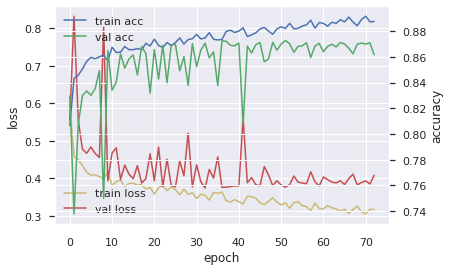

In [0]:
lr = 3e-4
n_epochs = 100
pat =  40
batchsize = 256*4
lr_d = 0.0
epoch =  500

X_train_f = tr.drop(['type_num'], axis = 1)
y_train_f = tr['type_num']

# Shuffle data
idx = np.arange(len(X_train_f))
np.random.shuffle(idx)
X_train_f = X_train_f.iloc[idx]
y_train_f = y_train_f.iloc[idx]

# Converting data to list for Enitity Embedding
proc_X_train_f, proc_X_test_f = preproc(X_train_f, X_test_f)

nn_model = build_embedding_network()

### model early stopping
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='auto') # 더이상 성능 개선이 되지 않으면 멈춤

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='auto', save_best_only=True)

import keras
optimizer = keras.optimizers.Adam(
    lr=lr,
)

## compile model
nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])








import os
MODEL_SAVE_FOLDER_PATH = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder +  '/rate=%s/' % lr
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
check_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH +"model1.h5"


## fitting model
hist = nn_model.fit(proc_X_train_f,
          y_train_f,
          batch_size=batchsize,
          validation_split=0.08,
          epochs=n_epochs,
          callbacks = [es ,mc
                       ])

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
#nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

Train on 182279 samples, validate on 15851 samples
Epoch 1/100
182279/182279 [==============================] - 9s 47us/step - loss: 0.8190 - acc: 0.7406 - val_loss: 0.5337 - val_acc: 0.8250
Epoch 2/100
182279/182279 [==============================] - 5s 27us/step - loss: 0.5016 - acc: 0.8333 - val_loss: 0.4663 - val_acc: 0.8481
Epoch 3/100
182279/182279 [==============================] - 5s 28us/step - loss: 0.4591 - acc: 0.8449 - val_loss: 0.4407 - val_acc: 0.8553
Epoch 4/100
182279/182279 [==============================] - 5s 27us/step - loss: 0.4414 - acc: 0.8499 - val_loss: 0.4395 - val_acc: 0.8546
Epoch 5/100
182279/182279 [==============================] - 5s 27us/step - loss: 0.4270 - acc: 0.8539 - val_loss: 0.4210 - val_acc: 0.8593
Epoch 6/100
182279/182279 [==============================] - 5s 27us/step - loss: 0.4172 - acc: 0.8568 - val_loss: 0.4117 - val_acc: 0.8618
Epoch 7/100
182279/182279 [==============================] - 5s 27us/step - loss: 0.4090 - acc: 0.8586 - val_

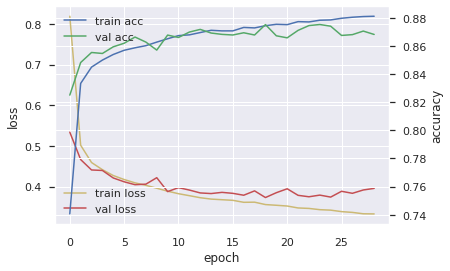

In [0]:
lr = 3e-4
n_epochs = 100
pat =  10
batchsize = 256*4
lr_d = 0.0
epoch =  500

X_train_f = tr.drop(['type_num'], axis = 1)
y_train_f = tr['type_num']

# Shuffle data
idx = np.arange(len(X_train_f))
np.random.shuffle(idx)
X_train_f = X_train_f.iloc[idx]
y_train_f = y_train_f.iloc[idx]

# Converting data to list for Enitity Embedding
proc_X_train_f, proc_X_test_f = preproc(X_train_f, X_test_f)

nn_model = build_embedding_network()

### model early stopping
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='auto') # 더이상 성능 개선이 되지 않으면 멈춤

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='auto', save_best_only=True)

import keras
optimizer = keras.optimizers.Adam(
    lr=lr,
)

## compile model
nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])








import os
MODEL_SAVE_FOLDER_PATH = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder +  '/rate=%s/' % lr
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
check_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH +"model1.h5"


## fitting model
hist = nn_model.fit(proc_X_train_f,
          y_train_f,
          batch_size=batchsize,
          validation_split=0.08,
          epochs=n_epochs,
          callbacks = [es ,mc
                       ])

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
#nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [0]:
savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + '/EntityEmbedding_GELU_rate_%s.csv' % rate
y_pred = nn_model.predict(proc_X_test_f)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(savingpath_csv, index=True)

In [0]:
best_ind = str(np.argmin(hist.history['val_loss'])+1)
best_loss = str(round(min(hist.history['val_loss']),4))
if len(best_ind) == 1:
  best_ind = '0'+best_ind
if len(best_loss)<6:
  diff = 6-len(best_loss)
  add_zero = ''
  for i in range(diff):
    add_zero = add_zero+'0'
  best_loss = best_loss + add_zero
best_check_name = best_ind + '-' + best_loss


## evaluate model

loss_and_metric = nn_model.evaluate(proc_X_train_f, y_train_f, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
## model weight save
nn_model.save_weights(weight_path)

## model load
check_path = MODEL_SAVE_FOLDER_PATH + best_check_name + ".hdf5"
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"

from tensorflow.keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(check_path)
print("Loaded model from disk")

## model load and evaluation
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
score = loaded_model.evaluate(proc_X_train_f,y_train_f,verbose=0, batch_size=batchsize)
print('='*50)
print("train, loss and metric: {}".format(score))


if loss_and_metric[0] < score[0]: ## 원래의 nn_model이 더 좋은 경우
  print('='*25)
  print('nn_model이 더 좋음')
  y_pred = nn_model.predict(proc_X_test_f)
  submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
  submission.to_csv(savingpath_csv, index=True)
  print('nn_model 사용해서 csv 저장완료')
else:
  print('='*25)
  print('load모델이 더 좋음')
  y_pred = loaded_model.predict(proc_X_test_f)
  submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
  submission.to_csv(savingpath_csv, index=True)
  print('loaded_model 사용해서 csv 저장완료')

print('='*50)
print("best_valid_loss: {}".format(best_loss))

if loss_and_metric[0] < score[0]: ## 원래의 nn_model이 더 좋은 경우
  print("nn_total_loss: {}".format(  round( loss_and_metric[0],5)  )   )
else:                             ## load 모델이 좋은 경우
  print("loaded_total_loss: {}".format(  round(score[0],5)  )  )

train, loss and metric: [0.32287228830481735, 0.885115833383672]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: ignored

# 하 밑에 K-Fold 왜 안되냐 ㄹㅇ

In [0]:
## 10-fold Cross-Validation
#network training
Nfold = 5
runs_per_fold = 3
lr = 3e-4
n_epochs = 20
pat =  10
batchsize = 256*3
lr_d = 0.0


#cv_ginis = []
full_val_preds = np.zeros(np.shape(X_train)[0])
y_preds = np.zeros(Nfold*len(X_test)*19).reshape(Nfold,len(X_test),19)

############################# Kfold & runs per fold - ensemble ########################

kfold = StratifiedKFold(n_splits = Nfold, 
                            random_state = 123, 
                            shuffle = True)    



X_train = tr.drop(['type_num'], axis = 1)
y_train = tr['type_num']

for enum, (train_index, valid_index) in enumerate(kfold.split(X_train, y_train)):
    
    X_train_f = X_train.loc[train_index].copy()
    X_val_f = X_train.loc[valid_index].copy()

    y_train_f = y_train[train_index]
    y_val_f = y_train[valid_index]
    
    X_test_f = tst.copy()
    
    #upsampling adapted from kernel: 
    #https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283
    #pos = (pd.Series(y_train_f == 1))
    
    # Add positive examples
    #X_train_f = pd.concat([X_train_f, X_train_f.loc[pos]], axis=0)
    #y_train_f = pd.concat([y_train_f, y_train_f.loc[pos]], axis=0)
    
    # Shuffle data
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f.iloc[idx]
    
    # Converting data to list for Enitity Embedding
    proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train_f, X_val_f, X_test_f)
    
    #track oof prediction for cv scores
    #val_preds = 0

    for j in range(runs_per_fold):
        print( '{0}번 Fold의 {1}번째 반복 시작'.format(enum,j) )
        check_path = SAVEMODEL_NEWFOLDER + f'/Entity_SWA_{Nfold}fold_NN_{enum}_{j}.hdf5'
        check_point = ModelCheckpoint(check_path, monitor="val_loss", verbose=1,save_best_only=True, mode="auto")
        early_stop = EarlyStopping(monitor="val_loss", mode="auto", patience=pat)
        cosine_scheduler = CosineAnnealingScheduler(T_max=100, eta_max=6e-4, eta_min=3e-5)
        swa = SWA(start_epoch=10, lr_schedule='manual', swa_lr=3e-4, swa_freq=5, verbose=1,batch_size=batchsize)
        NN = build_embedding_network()
        NN.fit(proc_X_train_f, y_train_f.values,
               validation_data=(proc_X_val_f, y_val_f),
               epochs=n_epochs,
               batch_size=batchsize,
               verbose=1,
               callbacks=[early_stop,
                          check_point
                          #cosine_scheduler,
                          #swa
                          ])
   
        #val_preds += NN.predict(proc_X_val_f)[:,0] / runs_per_fold
        y_preds[enum,:,:] += NN.predict(proc_X_test_f) / runs_per_fold
        print('{0}번 Fold의 {1}번째 반복 완료'.format(enum,j))
    print('='*100)

    #full_val_preds[valid_index] += val_preds
    #cv_gini = gini_normalizedc(y_val_f.values, val_preds)
    #cv_ginis.append(cv_gini)
    #print ('\nFold %i prediction cv gini: %.5f\n' %(enum,cv_gini))
    
#print('Mean out of fold gini: %.5f' % np.mean(cv_ginis))
#print('Full validation gini: %.5f' % gini_normalizedc(y_train.values, full_val_preds))

y_pred_final = np.zeros(len(X_test),19)
for fraction in range(y_preds.shape[0]):
  y_pred_final += y_preds[fraction,:,:]



y_pred_final = y_pred_final/y_preds.shape[0]


savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + f'/NN_EntityEmbed_{Nfold}fold_rate_{lr}.csv'

sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)
submission = sample_submission + y_pred_final
submission.to_csv(savingpath_csv)

## 1) 딥러닝 layer, node, Activation, Drop Out 등 결정

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import minmax_scale,StandardScaler
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout , Lambda, Flatten, LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam, SGD,RMSprop
from tensorflow.keras import  backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization # 배치정규화
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers


train =pd.read_csv('drive/My Drive/데이콘_천체유형/더미변환_ID별로모든변수스케일링_train.csv' ,index_col=None )
train_x = train.drop(['type_num'],axis=1)
train_x = train_x.iloc[:,:20]

train_y = train['type_num']

test_x = pd.read_csv('drive/My Drive/데이콘_천체유형/더미변환_ID별로모든변수스케일링_test.csv' ,index_col=0 )
sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)


### 노드수 선정할 때 주의할 점
* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer


### 노드수 결정하는 식

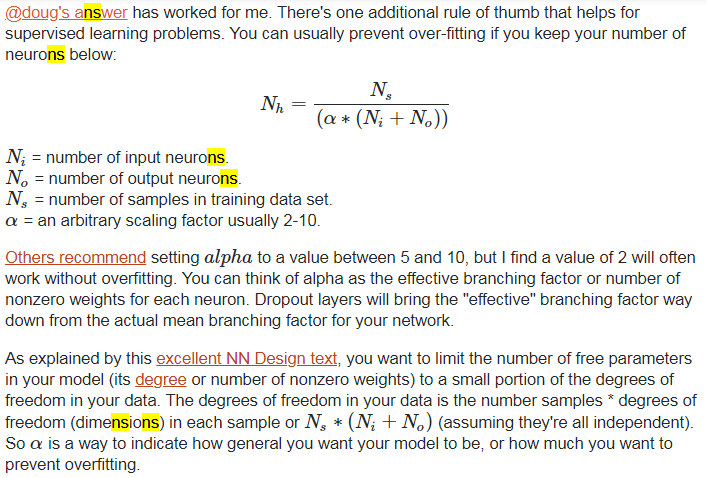

In [0]:
reg = regularizers.l2(0.0000001)
alpha = 1.0

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})

def custom_activation(x):
  return (K.tanh(x) * 145) + 155

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def create_nn_model(input_shape, alpha = 1.0):
    inp = Input(shape=input_shape)
    x = Dense(608)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
#    x = Dropout(0.1)(x)

    x = Dense(1205)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
    x = Dropout(0.2)(x)
    
    x = Dense(2397)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
    x = Dropout(0.15)(x)

    x = Dense(2394)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
    x = Dropout(0.15)(x)

    x = Dense(1462)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
#    x = Dropout(0.1)(x)

    x = Dense(1455)(inp)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
    x = Dropout(0.1)(x)

    x = Dense(531)(x)
    x = BatchNormalization()(x)
    x = ELU(alpha = alpha)(x)
#    x = Dropout(0.05)(x)


#    x = Dense(128)(x)
#    x = BatchNormalization()(x)
#    x = ELU(alpha = alpha)(x)
#    x = Dropout(0.1)(x)



    out = Dense(19, activation='softmax')(x) #scalar_coupling_constant    
    model = Model(inputs=inp, outputs=out)
    return model

nn_model = create_nn_model( input_shape=len(train_x.columns) )

## **※ csv파일 폴더 이름 바꾸기**

In [0]:
val = 0.1

In [0]:
csv_folder = '2월11일fID더미변환&모든변수_fID따로 스케일링'
rate = ''

import os
SAVEMODEL_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder
if not os.path.exists(SAVEMODEL_NEWFOLDER):
  os.mkdir(SAVEMODEL_NEWFOLDER)
SUBMISSION_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder
if not os.path.exists(SUBMISSION_NEWFOLDER):
  os.mkdir(SUBMISSION_NEWFOLDER)

savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + '/더미_스케일링_rate_%s.csv' % rate


## rate = 1e-4

Train on 178399 samples, validate on 19823 samples
Epoch 1/1000
178399/178399 [==============================] - 3s 15us/sample - loss: 0.4275 - acc: 0.8518 - val_loss: 0.4589 - val_acc: 0.8497
Epoch 2/1000
178399/178399 [==============================] - 1s 7us/sample - loss: 0.4263 - acc: 0.8512 - val_loss: 0.4588 - val_acc: 0.8496
Epoch 3/1000
178399/178399 [==============================] - 1s 6us/sample - loss: 0.4278 - acc: 0.8510 - val_loss: 0.4621 - val_acc: 0.8494
Epoch 4/1000
178399/178399 [==============================] - 1s 6us/sample - loss: 0.4268 - acc: 0.8514 - val_loss: 0.4623 - val_acc: 0.8490
Epoch 5/1000
178399/178399 [==============================] - 1s 6us/sample - loss: 0.4266 - acc: 0.8515 - val_loss: 0.4631 - val_acc: 0.8479
Epoch 6/1000
178399/178399 [==============================] - 1s 6us/sample - loss: 0.4269 - acc: 0.8516 - val_loss: 0.4644 - val_acc: 0.8471
Epoch 7/1000
178399/178399 [==============================] - 1s 6us/sample - loss: 0.4272 - acc

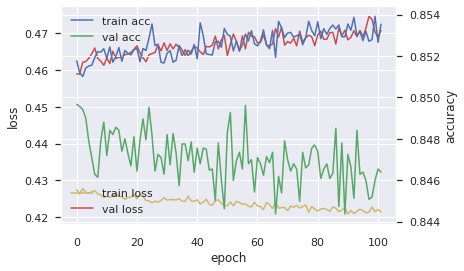

In [0]:
epoch =  1000
pat =  100


batchsize = 256*3
rate = 1e-4


import os
MODEL_SAVE_FOLDER_PATH = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder +  '/rate=%s/' % rate
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
check_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH +"model1.h5"

### model early stopping
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='auto') # 더이상 성능 개선이 되지 않으면 멈춤

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='auto', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=rate,
)

## compile model
nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## fitting model
hist = nn_model.fit(train_x,
          train_y,
          batch_size=batchsize,
          validation_split=val,
          epochs=epoch,
          callbacks = [es ,mc
                       ])

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
#nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

Train on 188310 samples, validate on 9912 samples
Epoch 1/10000
188310/188310 [==============================] - 3s 15us/sample - loss: 0.8812 - acc: 0.7429 - val_loss: 1.3249 - val_acc: 0.6103
Epoch 2/10000
188310/188310 [==============================] - 1s 7us/sample - loss: 0.7108 - acc: 0.7790 - val_loss: 0.7459 - val_acc: 0.7612
Epoch 3/10000
188310/188310 [==============================] - 1s 7us/sample - loss: 0.6804 - acc: 0.7853 - val_loss: 0.6502 - val_acc: 0.7975
Epoch 4/10000
188310/188310 [==============================] - 1s 7us/sample - loss: 0.6571 - acc: 0.7903 - val_loss: 0.6396 - val_acc: 0.7991
Epoch 5/10000
188310/188310 [==============================] - 1s 7us/sample - loss: 0.6441 - acc: 0.7926 - val_loss: 0.6216 - val_acc: 0.8008
Epoch 6/10000
188310/188310 [==============================] - 1s 6us/sample - loss: 0.6315 - acc: 0.7949 - val_loss: 0.6226 - val_acc: 0.8017
Epoch 7/10000
188310/188310 [==============================] - 1s 6us/sample - loss: 0.6222

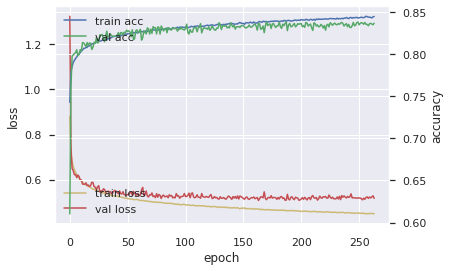

In [0]:
epoch =  1000
pat =  100


batchsize = 256*3


import os
MODEL_SAVE_FOLDER_PATH = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder +  '/rate=%s/' % rate
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
check_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH +"model1.h5"

### model early stopping
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='auto') # 더이상 성능 개선이 되지 않으면 멈춤

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='auto', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=rate,
)

## compile model
nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## fitting model
hist = nn_model.fit(train_x,
          train_y,
          batch_size=batchsize,
          validation_split=val,
          epochs=epoch,
          callbacks = [es ,mc
                       ])

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
#nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

### SCORE 확인, 저장

In [0]:
best_ind = str(np.argmin(hist.history['val_loss'])+1)
best_loss = str(round(min(hist.history['val_loss']),4))
if len(best_ind) == 1:
  best_ind = '0'+best_ind
if len(best_loss)<6:
  diff = 6-len(best_loss)
  add_zero = ''
  for i in range(diff):
    add_zero = add_zero+'0'
  best_loss = best_loss + add_zero
best_check_name = best_ind + '-' + best_loss


## evaluate model

loss_and_metric = nn_model.evaluate(train_x, train_y, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
## model weight save
nn_model.save_weights(weight_path)

## model load
check_path = MODEL_SAVE_FOLDER_PATH + best_check_name + ".hdf5"
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"

from tensorflow.keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(check_path)
print("Loaded model from disk")

## model load and evaluation
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
score = loaded_model.evaluate(train_x,train_y,verbose=0, batch_size=batchsize)
print('='*50)
print("train, loss and metric: {}".format(score))


if loss_and_metric[0] < score[0]: ## 원래의 nn_model이 더 좋은 경우
  print('='*25)
  print('nn_model이 더 좋음')
  y_pred = nn_model.predict(test_x)
  submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
  submission.to_csv(savingpath_csv, index=True)
  print('nn_model 사용해서 csv 저장완료')
else:
  print('='*25)
  print('load모델이 더 좋음')
  y_pred = loaded_model.predict(test_x)
  submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
  submission.to_csv(savingpath_csv, index=True)
  print('loaded_model 사용해서 csv 저장완료')

print('='*50)
print("best_valid_loss: {}".format(best_loss))

if loss_and_metric[0] < score[0]: ## 원래의 nn_model이 더 좋은 경우
  print("nn_total_loss: {}".format(  round( loss_and_metric[0],5)  )   )
else:                             ## load 모델이 좋은 경우
  print("loaded_total_loss: {}".format(  round(score[0],5)  )  )

train, loss and metric: [0.15572783328422357, 0.95219]
Loaded model from disk
train, loss and metric: [0.37825581353297993, 0.8695705]
nn_model이 더 좋음
nn_model 사용해서 csv 저장완료
best_valid_loss: 0.5271
nn_total_loss: 0.15573
